# COMP 551 - Assignment 1

Rex Hamilton, Simon Arts, Talia Cooper



# Data Collection and Data Cleaning

import and install statements

In [ ]:
import numpy as np
import pandas as pd
!pip install ucimlrepo
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


Data collection (Fetch) functions

In [ ]:
def fetch_data_nutrition():
  #import
  from ucimlrepo import fetch_ucirepo

  # fetch dataset
  national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset = fetch_ucirepo(id=887)

  # data (as pandas dataframes)
  X = national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset.data.features
  y = national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset.data.targets

  df = pd.DataFrame(X)
  # summary = df.describe()
  # print(summary)

  df["y"] = y
  df = df.dropna()
  Y = df["y"]
  df = df.drop(columns=['y'])

  df = df.to_numpy()
  Y = Y.to_numpy()

  Y = (Y == "Adult").astype(int).flatten()

  return (df, Y)

# fetch_data_nutrition()

In [ ]:
def fetch_data_breastcancer():
  from ucimlrepo import fetch_ucirepo

  # fetch dataset
  breast_cancer_wisconsin_original = fetch_ucirepo(id=15)

  # data (as pandas dataframes)
  X = breast_cancer_wisconsin_original.data.features
  y = breast_cancer_wisconsin_original.data.targets

  df = pd.DataFrame(X)
  # summary = df.describe()
  # print(summary)

  df["y"] = y
  df = df.dropna()
  Y = df["y"]
  df = df.drop(columns=['y'])

  df = df.to_numpy()
  Y = Y.to_numpy()

  Y = (Y == 4).astype(int).flatten()

  return (df, Y)

# fetch_data_breastcancer()

Statistic Functions

In [ ]:
def stats(X, y):

  X= pd.DataFrame(X)
  y= pd.DataFrame(y)

  df = X.copy(True)
  df["y"] = y

  df_be = df[df["y"] == 1]
  df_ml = df[df["y"] == 0]

  print("Target Feature Means : ")
  print(df_be.mean(numeric_only=True))
  print("\nNon Target Feature Means : ")
  print(df_ml.mean(numeric_only=True))
  print("\nSquare Diff between Group Means : ")
  df_sq_diff = (df_be.mean(numeric_only=True) - df_ml.mean(numeric_only=True)).pow(2).sort_values(ascending=False)
  print(df_sq_diff)

#nutrition_data = fetch_data_nutrition()
#stats(nutrition_data[0],nutrition_data[1])

#breast_cancer_data = fetch_data_breastcancer()
#stats(breast_cancer_data[0],breast_cancer_data[1])

# KNN Class

KNN Class

---



In [ ]:
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class KNN:

    def __init__(self, K=1, dist_fn= euclidean):
        self.dist_fn = dist_fn
        self.K = K
        return

    def fit(self, x, y):
        self.x = x
        self.y = y
        self.C = 2
        return self

    def predict(self, x_test):
        num_test = x_test.shape[0]
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        knns = np.zeros((num_test, self.K), dtype=int)
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C)
        y_prob /= self.K
        return y_prob, knns


# Decision Tree Class

**Decision Tree**


---



In [ ]:
# DT Classes and Implementations:

class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices
        self.left = None
        self.right = None
        self.split_feature = None
        self.split_value = None
        if parent:
            self.depth = parent.depth + 1
            self.num_classes = parent.num_classes
            self.data = parent.data
            self.labels = parent.labels
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes)
            self.class_prob = class_prob / np.sum(class_prob)

def greedy_test(node, cost_fn):
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

def cost_misclassification(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]
    return -np.sum(class_probs * np.log2(class_probs))

def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))


class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        self.max_depth = max_depth
        self.root = None
        self.cost_fn = cost_fn
        self.num_classes = num_classes
        self.min_leaf_instances = min_leaf_instances

    def feature_importance(self):
        importance_counts = np.zeros(len(self.data[0]))
        self._calc_feature_importance(self.root, importance_counts)
        return importance_counts

    def _calc_feature_importance(self, node, importance_counts):
        if node.left is not None and node.right is not None:
            importance_counts[node.split_feature] += 1
            self._calc_feature_importance(node.left, importance_counts)
            self._calc_feature_importance(node.right, importance_counts)


def fit(self, data, labels):
    self.data = data
    self.labels = labels
    if self.num_classes is None:
        self.num_classes = 2
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    self._fit_tree(self.root)
    return self

def _fit_tree(self, node):
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    if np.isinf(cost):
        return
    test = node.data[node.data_indices,split_feature] <= split_value
    node.split_feature = split_feature
    node.split_value = split_value
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    self._fit_tree(left)
    self._fit_tree(right)
    node.left = left
    node.right = right

DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree

def predict(self, data_test):
    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    for n, x in enumerate(data_test):
        node = self.root
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        class_probs[n,:] = node.class_prob
    return class_probs


DecisionTree.predict = predict

# Helper Functions

**Helper Functions**

Split by half - takes X & y data and randomly splits the two in half, returning a 4 tuple (x_train, y_train, x_test, y_test).

In [ ]:
def split_by_half(X, y):

  N = len(X)

  inds = np.random.permutation(N)

  x_train, y_train = X[inds[:N//2]], y[inds[:N//2]]
  x_test, y_test = X[inds[N//2:]], y[inds[N//2:]]

  return (x_train, y_train, x_test, y_test)

Predict Labels - Takes a y probability array and returns the predicted labels (0 or 1)

In [ ]:
def predict_labels(y_probs):
  i=0
  N=y_probs.shape[0] - 1


  y_predicted_labels = np.zeros(N, dtype=int)

  for i in range(N):
    y_predicted_labels[i] = np.argmax(y_probs[i])

  return y_predicted_labels


Evaluate Accuracy Function

In [ ]:
def evaluate_acc(y, predicted_y):
  correct = 0
  N = y.shape[0] - 1

  for i in range(N):
    if y[i] == predicted_y[i]:
      correct+=1

  return (correct/N)*100

# Selecting Optimal K and Max Tree Depths (Optional) & Constructing General Models


Split - takes X & y data and randomly splits into 50% Training, 25% Validation and 25% testing

In [ ]:
def split(X, y):

  N = len(X)

  inds = np.random.permutation(N)

  x_train, y_train = X[inds[N//2:]], y[inds[N//2:]]
  x_test, y_test = X[inds[:N//4]], y[inds[:N//4]]
  x_validate, y_validate = X[inds[N//4:N//2]], y[inds[N//4:N//2]]

  return (x_train, y_train, x_test, y_test, x_validate, y_validate)



In [ ]:
def optimal_k(x_train, y_train, x_test, y_test, x_validate, y_validate, max):

  opt_k = 1
  opt_acc = -1
  k = 1

  while k < max:

    model = KNN(k)

    model.fit(x_train, y_train)

    y_probs, knn = model.predict(x_validate)

    y_labels = predict_labels(y_probs)

    acc = evaluate_acc(y_validate, y_labels)

    if acc > opt_acc:

      opt_acc = acc
      opt_k = k

    k+=2

  print("Optimal K: " + str(opt_k))
  print("Optimal acc: " + str(opt_acc))

  return opt_k


In [ ]:
def optimal_depth(x_train, y_train, x_test, y_test, x_validate, y_validate, max):

  opt_depth = 1
  opt_acc = -1
  depth = 1

  while depth < max:

    model = DecisionTree(max_depth=depth)

    model.fit(x_train, y_train)

    y_probs = model.predict(x_validate)

    y_labels = predict_labels(y_probs)

    acc = evaluate_acc(y_validate, y_labels)

    if acc > opt_acc:

      opt_acc = acc
      opt_depth = depth

    depth+=2

  print("Optimal depth: " + str(opt_depth))
  print("Optimal acc: " + str(opt_acc))

  return opt_depth


Here we will **construct Generic KNN and DT objects for each Dataset using the optimal k and max depth values**. These will be used as the default inputs for other process throughout the notebook (see AUROC curves and Visualization).

In [ ]:
# Nutrition
# Fetch Data for Nutrition

X_n, y_n = fetch_data_nutrition()

x_n_train, y_n_train, x_n_test, y_n_test, x_n_validate, y_n_validate = split(X_n, y_n)

k_n = optimal_k(x_n_train, y_n_train, x_n_test, y_n_test, x_n_validate, y_n_validate, 20)
depth_n = optimal_depth(x_n_train, y_n_train, x_n_test, y_n_test, x_n_validate, y_n_validate, 20)

nutrition_knn_model = KNN(k_n)
nutrition_dt_model = DecisionTree(max_depth=depth_n, cost_fn=cost_gini_index )

Optimal K: 17
Optimal acc: 83.83128295254832
Optimal depth: 1
Optimal acc: 83.83128295254832


In [ ]:
# Breast Cancer
# Fetch Data for Breast_cancer

X_bc, y_bc = fetch_data_breastcancer()

x_bc_train, y_bc_train, x_bc_test, y_bc_test, x_bc_validate, y_bc_validate = split(X_bc, y_bc)

k_bc = optimal_k(x_bc_train, y_bc_train, x_bc_test, y_bc_test, x_bc_validate, y_bc_validate, 20)
depth_bc = optimal_depth(x_bc_train, y_bc_train, x_bc_test, y_bc_test, x_bc_validate, y_bc_validate, 20)

breast_cancer_knn_model = KNN(k_bc)
breast_cancer_dt_model = DecisionTree(max_depth=depth_bc, cost_fn=cost_gini_index)

Optimal K: 3
Optimal acc: 97.05882352941177
Optimal depth: 5
Optimal acc: 97.05882352941177


# Experiments

**Experiment (1)** Comparing the accuracy and AUROC of KNN and DT algorithm on the two datasets

**Experiment (5)** Plot the ROC for KNN and DT on the test data. Both ROC curves need to be plotted on
the same plot to enable comparison between of the method performance. Also show the
AUROC of each method in the figure legend.

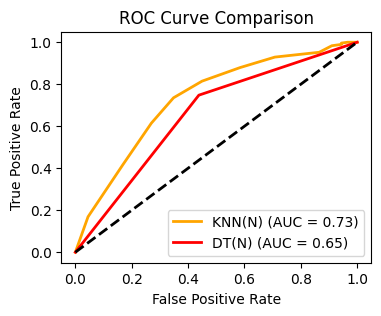

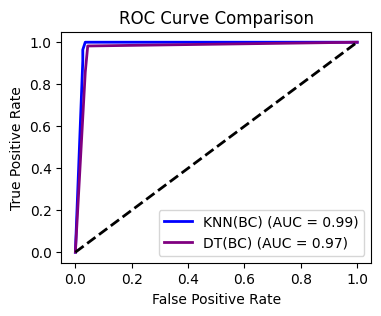

In [ ]:
# Experiment 1 - AUROC
def auroc():

  # get probabilities for dt & knn datasets

  # Nurtrition
  # KNN probs
  prob_n_knn, knns_n = nutrition_knn_model.fit(x_n_train, y_n_train).predict(x_n_test)

  # DT probs
  nutrition_dt_model.fit(x_n_train, y_n_train)
  prob_n_dt = nutrition_dt_model.predict(x_n_test)

  # Breast Cancer
  # KNN probs
  prob_bc_knn, knns_bc = breast_cancer_knn_model.fit(x_bc_train, y_bc_train).predict(x_bc_test)

  # DT probs
  breast_cancer_dt_model.fit(x_bc_train, y_bc_train)
  prob_bc_dt = breast_cancer_dt_model.predict(x_bc_test)


  # fprs and tprs for ROC's

  # Nutrition
  fpr_n_knn, tpr_n_knn, _ = roc_curve(y_n_test, prob_n_knn[:, 1])
  roc_auc_n_knn = roc_auc_score(y_n_test, prob_n_knn[:, 1])

  fpr_n_dt, tpr_n_dt, _ = roc_curve(y_n_test, prob_n_dt[:, 1])
  roc_auc_n_dt = roc_auc_score(y_n_test, prob_n_dt[:, 1])

  # Breast Cancer
  fpr_bc_knn, tpr_bc_knn, _ = roc_curve(y_bc_test, prob_bc_knn[:, 1])
  roc_auc_bc_knn = roc_auc_score(y_bc_test, prob_bc_knn[:, 1])

  fpr_bc_dt, tpr_bc_dt, _ = roc_curve(y_bc_test, prob_bc_dt[:, 1])
  roc_auc_bc_dt = roc_auc_score(y_bc_test, prob_bc_dt[:, 1])


  # Creating roc plot

  plt.figure(figsize=(4, 3))

  plt.plot(fpr_n_knn, tpr_n_knn, color='orange', lw=2, label='KNN(N) (AUC = %0.2f)' % roc_auc_n_knn)
  plt.plot(fpr_n_dt, tpr_n_dt, color='red', lw=2, label='DT(N) (AUC = %0.2f)' % roc_auc_n_dt)

  plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve Comparison')
  plt.legend(loc="lower right")
  plt.show()

  plt.figure(figsize=(4, 3))

  plt.plot(fpr_bc_knn, tpr_bc_knn, color='blue', lw=2, label='KNN(BC) (AUC = %0.2f)' % roc_auc_bc_knn)
  plt.plot(fpr_bc_dt, tpr_bc_dt, color='purple', lw=2, label='DT(BC) (AUC = %0.2f)' % roc_auc_bc_dt)

  plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve Comparison')
  plt.legend(loc="lower right")

auroc()

**Experiment (2)**  - Testing different K values, to determine which results in the best accuracy.

In [ ]:
# Experiment (2) - Test different K values and see how it affects the training
# data accuracy and test data accuracy of KNN

def test_knn(num_of_models, x_train, y_train, x_test, y_test):

  k = 1
  n = 1
  while n <= num_of_models:

    model = KNN(k)

    y_prob_test, knns = model.fit(x_train, y_train).predict(x_test)
    y_prob_train, knns = model.fit(x_train, y_train).predict(x_train)


    N_train = y_train.shape[0]
    N_test = y_test.shape[0]

    y_predicted_labels_test = np.zeros(N_test, dtype=int)
    y_predicted_labels_train = np.zeros(N_train, dtype=int)

    i=0
    for i in range(N_test):
      y_predicted_labels_test[i] = np.argmax(y_prob_test[i])

    j=0
    for j in range(N_train):
      y_predicted_labels_train[j] = np.argmax(y_prob_train[j])

    test_acc = evaluate_acc(y_test, y_predicted_labels_test)
    train_acc = evaluate_acc(y_train, y_predicted_labels_train)

    print("-" * 50)
    print("\n K = " , k)
    print("\n Test Accuracy" , test_acc)
    print("\n Train Accuracy" , train_acc)
    n+=1
    k+=2


In [ ]:
#Running Experiment (2)

# CHANGE FIRST PARAMETER TO SEE MORE TESTS

# Nutrition Data
print("Nutrition Dataset : ")
test_knn(1, x_n_train, y_n_train, x_n_test, y_n_test)

# Breast Cancer Data
print("\n \n Breast Cancer Dataset : ")
test_knn(1, x_bc_train, y_bc_train, x_bc_test, y_bc_test)


Nutrition Dataset : 
--------------------------------------------------

 K =  1

 Test Accuracy 78.16901408450704

 Train Accuracy 100.0

 
 Breast Cancer Dataset : 
--------------------------------------------------

 K =  1

 Test Accuracy 98.22485207100591

 Train Accuracy 100.0


**Experiment (3)** Testing different max tree depths, to determine which results in the best accuracy.

In [ ]:
# Experiment 3

def test_dt(num_of_models, x_train, y_train, x_test, y_test):

  k = 1
  n = 1
  while n <= num_of_models:

    model = DecisionTree(max_depth=k)

    y_prob_test = model.fit(x_train, y_train).predict(x_test)
    y_prob_train = model.fit(x_train, y_train).predict(x_train)


    N_train = y_train.shape[0]
    N_test = y_test.shape[0]

    y_predicted_labels_test = np.zeros(N_test, dtype=int)
    y_predicted_labels_train = np.zeros(N_train, dtype=int)

    i=0
    for i in range(N_test):
      y_predicted_labels_test[i] = np.argmax(y_prob_test[i])

    j=0
    for j in range(N_train):
      y_predicted_labels_train[j] = np.argmax(y_prob_train[j])

    test_acc = evaluate_acc(y_test, y_predicted_labels_test)
    train_acc = evaluate_acc(y_train, y_predicted_labels_train)

    print("-" * 50)
    print("\n Depth = " , k)
    print("\n Test Accuracy" , test_acc)
    print("\n Train Accuracy" , train_acc)
    n+=1
    k+=2

In [ ]:
#Running Experiment (3)

# CHANGE FIRST PARAMETER TO SEE MORE TESTS

# Nutrition Data
print("Nutrition Dataset : ")
test_dt(1, x_n_train, y_n_train, x_n_test, y_n_test)

# Breast Cancer Data
print("n Breast Cancer Dataset : ")
test_dt(1, x_bc_train, y_bc_train, x_bc_test, y_bc_test)


Nutrition Dataset : 
--------------------------------------------------

 Depth =  1

 Test Accuracy 84.33098591549296

 Train Accuracy 84.00702987697716
n Breast Cancer Dataset : 
--------------------------------------------------

 Depth =  1

 Test Accuracy 95.26627218934911

 Train Accuracy 92.66862170087975


**Experiment (4)** Testing Alternative Cost Functions

In [ ]:
#KNN
def cost_functions_knn():
  nutrition_dist_euclidean = KNN(5, dist_fn=euclidean)
  nutrition_dist_manhattan = KNN(5, dist_fn=manhattan)

  nutrition_dist_euclidean.fit(x_n_train, y_n_train)
  nutrition_dist_euclidean_prob, knn = nutrition_dist_euclidean.predict(x_n_test)
  nutrition_dist_euclidean_labels = predict_labels(nutrition_dist_euclidean_prob)
  print("Euclidean Distance Accuracy on Nutrition Data: "+str(evaluate_acc(y_n_test, nutrition_dist_euclidean_labels)))

  nutrition_dist_manhattan.fit(x_n_train, y_n_train)
  nutrition_dist_manhattan_prob, knn = nutrition_dist_manhattan.predict(x_n_test)
  nutrition_dist_manhattan_labels = predict_labels(nutrition_dist_manhattan_prob)
  print("Manhattan Distance Accuracy on Nutrition Data: "+str(evaluate_acc(y_n_test, nutrition_dist_manhattan_labels)))

  breastcancer_dist_euclidean = KNN(5, dist_fn=euclidean)
  breastcancer_dist_manhattan = KNN(5, dist_fn=manhattan)

  breastcancer_dist_euclidean.fit(x_bc_train, y_bc_train)
  breastcancer_dist_euclidean_prob, knn = breastcancer_dist_euclidean.predict(x_bc_test)
  breastcancer_dist_euclidean_labels = predict_labels(breastcancer_dist_euclidean_prob)
  print("Euclidean Distance Accuracy on Breast Cancer Data: "+str(evaluate_acc(y_bc_test, breastcancer_dist_euclidean_labels)))

  breastcancer_dist_manhattan.fit(x_bc_train, y_bc_train)
  breastcancer_dist_manhattan_prob, knn = breastcancer_dist_manhattan.predict(x_bc_test)
  breastcancer_dist_manhattan_labels = predict_labels(breastcancer_dist_manhattan_prob)
  print("Manhattan Distance Accuracy on Breast Cancer Data: "+str(evaluate_acc(y_bc_test, breastcancer_dist_manhattan_labels)))

cost_functions_knn()


Euclidean Distance Accuracy on Nutrition Data: 83.45070422535211
Manhattan Distance Accuracy on Nutrition Data: 82.21830985915493
Euclidean Distance Accuracy on Breast Cancer Data: 97.63313609467455
Manhattan Distance Accuracy on Breast Cancer Data: 97.63313609467455


In [ ]:
# Decision Tree

def cost_functions_dt():
  nutrition_cost_misclassification = DecisionTree(max_depth=10, cost_fn=cost_misclassification)
  bc_cost_misclassification = DecisionTree(max_depth=10, cost_fn=cost_misclassification)
  nutrition_entropy = DecisionTree(max_depth=10, cost_fn=cost_entropy)
  bc_entropy = DecisionTree(max_depth=10, cost_fn=cost_entropy)
  nutrition_gini = DecisionTree(max_depth=10, cost_fn=cost_gini_index)
  bc_gini = DecisionTree(max_depth=10, cost_fn=cost_gini_index)

  nutrition_cost_misclassification.fit(x_n_train, y_n_train)
  nutrition_cost_misclassification_prob = nutrition_cost_misclassification.predict(x_n_test)
  nutrition_cost_misclassification_prob = predict_labels(nutrition_cost_misclassification_prob)
  print("Cost Misclassification Accuracy on Nutrition Data: "+str(evaluate_acc(y_n_test, nutrition_cost_misclassification_prob)))

  nutrition_entropy.fit(x_n_train, y_n_train)
  nutrition_entropy_prob = nutrition_entropy.predict(x_n_test)
  nutrition_entropy_prob = predict_labels(nutrition_entropy_prob)
  print("Entropy Accuracy on Nutrition Data: "+str(evaluate_acc(y_n_test, nutrition_entropy_prob)))

  nutrition_gini.fit(x_n_train, y_n_train)
  nutrition_gini_prob = nutrition_gini.predict(x_n_test)
  nutrition_gini_prob = predict_labels(nutrition_gini_prob)
  print("Gini Index Accuracy on Nutrition Data: "+str(evaluate_acc(y_n_test, nutrition_gini_prob)))

  bc_cost_misclassification.fit(x_bc_train, y_bc_train)
  bc_cost_misclassification_prob = bc_cost_misclassification.predict(x_bc_test)
  bc_cost_misclassification_prob = predict_labels(bc_cost_misclassification_prob)
  print("Cost Misclassification Accuracy on Breast Cancer Data: "+str(evaluate_acc(y_bc_test, bc_cost_misclassification_prob)))

  bc_entropy.fit(x_bc_train, y_bc_train)
  bc_entropy_prob = bc_cost_misclassification.predict(x_bc_test)
  bc_entropy_prob = predict_labels(bc_entropy_prob)
  print("Entropy Accuracy on Breast Cancer Data: "+str(evaluate_acc(y_bc_test, bc_entropy_prob)))

  bc_gini.fit(x_bc_train, y_bc_train)
  bc_gini_prob = bc_gini.predict(x_bc_test)
  bc_gini_prob = predict_labels(bc_gini_prob)
  print("Gini Index Accuracy on Breast Cancer Data: "+str(evaluate_acc(y_bc_test, bc_gini_prob)))

cost_functions_dt()

Cost Misclassification Accuracy on Nutrition Data: 84.15492957746478
Entropy Accuracy on Nutrition Data: 77.8169014084507
Gini Index Accuracy on Nutrition Data: 77.46478873239437
Cost Misclassification Accuracy on Breast Cancer Data: 96.44970414201184
Entropy Accuracy on Breast Cancer Data: 96.44970414201184
Gini Index Accuracy on Breast Cancer Data: 95.26627218934911


**Experiment (6)** Obtaining Key features of KNN.
When looking at the stats functions as well as the plot below we can determine that many of the fields do not contribute to a difference between the classes.

In the stats function many fields have a low squared difference of means.
In the plot, there is ver little correllation between many of the classes.

I will maintain the top 3 correlated fields of each dataset and drop the others, then I will compare to the orignal KNN model for each dataset

In [ ]:
#Experiment 6 Obtaining Key KNN features.

#Drop all the fields not within the top 3 squared difference ranked from highest to lowest.

def only_correlated(X, y, n):

  X = pd.DataFrame(X)
  y = pd.DataFrame(y)

  df = X.copy()
  df["y"] = y

  df_be = df[df["y"] == 1]
  df_ml = df[df["y"] == 0]

  df_be = df_be.drop(['y'], axis=1)
  df_ml = df_ml.drop(['y'], axis=1)

  df_sq_diff = (df_be.mean(numeric_only=True) - df_ml.mean(numeric_only=True)).pow(2).argsort()

  non_correlated_cols = df_sq_diff[:df_sq_diff.shape[0]-n]
  df = df.drop(non_correlated_cols, axis=1)

  y_rem = df["y"].to_numpy()
  X_rem = df.drop('y', axis=1).to_numpy()

  x_train_rem, y_train_rem, x_test_rem, y_test_rem = split_by_half(X_rem, y_rem)

  return(x_train_rem, y_train_rem, x_test_rem, y_test_rem)


oc_n = only_correlated(X_n, y_n, 3)

# CHANGE FIRST PARAMETER TO SEE MORE TESTS

print("\n Nutrition Top 3 Collumns")
test_knn(1, oc_n[0], oc_n[1], oc_n[2], oc_n[3])


print("\n Nutrition All Collumns")
test_knn(1, x_n_train, y_n_train, x_n_test, y_n_test)

oc_bc = only_correlated(X_bc, y_bc, 3)

print("\n Breast Cancer Top 3 Collumns")
test_knn(1, oc_bc[0], oc_bc[1], oc_bc[2], oc_bc[3])


print("\n Breast Cancer All Collumns")
test_knn(1, x_bc_train, y_bc_train, x_bc_test, y_bc_test)




 Nutrition Top 3 Collumns
--------------------------------------------------

 K =  1

 Test Accuracy 77.68014059753953

 Train Accuracy 100.0

 Nutrition All Collumns
--------------------------------------------------

 K =  1

 Test Accuracy 78.16901408450704

 Train Accuracy 100.0

 Breast Cancer Top 3 Collumns
--------------------------------------------------

 K =  1

 Test Accuracy 94.13489736070382

 Train Accuracy 98.82352941176471

 Breast Cancer All Collumns
--------------------------------------------------

 K =  1

 Test Accuracy 98.22485207100591

 Train Accuracy 100.0


**Experiment(7)** Computing a rough feature importance score for each feature d by counting the number of non-leaf nodes where feature d is used.


In [ ]:
def find_importance(X, y, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1, top_features_count=9):

    x_train, y_train, x_test, y_test = only_correlated(X, y, top_features_count)
    tree = DecisionTree(num_classes=num_classes, max_depth=max_depth, cost_fn=cost_fn, min_leaf_instances=min_leaf_instances)
    tree.fit(x_train, y_train)
    importance_scores = tree.feature_importance()

    top_features_indices = np.argsort(importance_scores)[-top_features_count:]

    print("Top {} Features:".format(top_features_count))
    for i in top_features_indices:
        print("Feature {}: Importance Score: {}".format(i, importance_scores[i]))

    return x_train, y_train, x_test, y_test, top_features_indices

print("\nNutrition Feature Importance: \n")
X_n, y_n = fetch_data_nutrition()
x_n_train, y_n_train, x_n_test, y_n_test, top_features = find_importance(X_n, y_n, top_features_count=7)

print("\nBreast Cancer Feature Importance: \n")
X_bc, y_bc = fetch_data_breastcancer()
x_bc_train, y_bc_train, x_bc_test, y_bc_test, top_features = find_importance(X_bc, y_bc, top_features_count=9)



Nutrition Feature Importance: 

Top 7 Features:
Feature 3: Importance Score: 0.0
Feature 4: Importance Score: 0.0
Feature 5: Importance Score: 0.0
Feature 0: Importance Score: 1.0
Feature 1: Importance Score: 1.0
Feature 6: Importance Score: 1.0
Feature 2: Importance Score: 4.0

Breast Cancer Feature Importance: 

Top 9 Features:
Feature 3: Importance Score: 0.0
Feature 4: Importance Score: 0.0
Feature 7: Importance Score: 0.0
Feature 0: Importance Score: 1.0
Feature 1: Importance Score: 1.0
Feature 5: Importance Score: 1.0
Feature 6: Importance Score: 1.0
Feature 8: Importance Score: 1.0
Feature 2: Importance Score: 2.0


# Additional Testing & Optional Experiments

Optional Experiment - K Cross fold validation

In [ ]:
from sklearn.model_selection import KFold

def cross_validate(model, X, Y):

    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    y = np.array([0] * X.shape[0])
    yh = np.empty((X.shape[0], 2))

    for train_index, test_index in kf.split(X):

        model.fit(X[train_index], Y[train_index])

        y[test_index] = Y[test_index]
        yh[test_index] = model.predict(X[test_index])[0]

    return y, yh


nutrition_knn_kfold = KNN(k_n)
print("KNN : " +  str(k_n))

def_knn = KNN(k_n)

def_knn.fit(x_n_train, y_n_train)
probs, knn = def_knn.predict(x_n_test)
pred = predict_labels(probs)

print("Accuracy of regular knn: " + str(evaluate_acc(y_n_test, pred)))


y_true_n, y_n_probs = cross_validate(nutrition_knn_kfold, X_n, y_n)
y_n_predicted = predict_labels(y_n_probs)

print("Accuracy of performing K cross fold validation : " + str(evaluate_acc(y_n, y_n_predicted)))



KNN : 17
Accuracy of regular knn: 83.39191564147627
Accuracy of performing K cross fold validation : 83.399209486166


Optional Experiment - Implementing k-cross fold validation

# Plots & Visualization

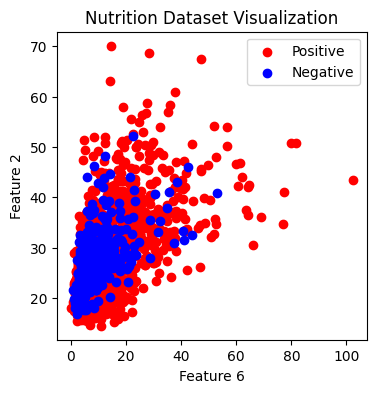

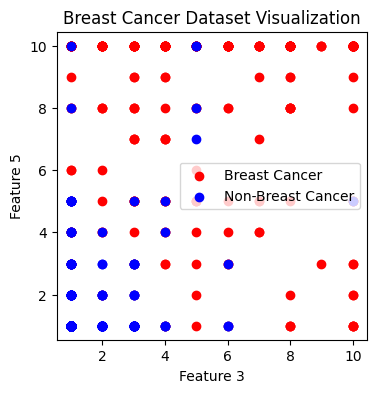

In [ ]:
# Plot to show signifigant KNN features

x_axis = X_n[:, 6]
y_axis = X_n[:, 2]

# Differentiate the classes
class_1 = y_n == 1  # Assuming class '1' indicates breast cancer
class_0 = y_n == 0  # Assuming class '0' indicates no breast cancer

plt.figure(figsize=(4, 4))
plt.scatter(x_axis[class_1], y_axis[class_1], color='red', label='Positive')
plt.scatter(x_axis[class_0], y_axis[class_0], color='blue', label='Negative')
plt.xlabel('Feature 6')
plt.ylabel('Feature 2')
plt.title('Nutrition Dataset Visualization')
plt.legend()
plt.show()

# Breast Cancer Visualization

x_axis = X_bc[:, 3]
y_axis = X_bc[:, 5]

class_1 = y_bc == 1
class_0 = y_bc == 0

plt.figure(figsize=(4, 4))
plt.scatter(x_axis[class_1], y_axis[class_1], color='red', label='Breast Cancer')
plt.scatter(x_axis[class_0], y_axis[class_0], color='blue', label='Non-Breast Cancer')
plt.xlabel('Feature 3')
plt.ylabel('Feature 5')
plt.title('Breast Cancer Dataset Visualization')
plt.legend()
plt.show()

